# Plot Pinckney HPLC data
1. read files
2. melt data to appropriate format for plotting
3. recreate plots in publication
4. extract data relevant for model verification

what do i want to show Andrew?
- the functional type data, data coverage 
    - and which functional types are actually defined
    - read up quickly on each type defined and what is meant by the name
- the new model schematics, so which functional types do I want to model?


...

In [32]:
require(tidyverse, warn.conflicts = FALSE);
require(cowplot, warn.conflicts = FALSE); # for nicer plots, includes ggplot2

require(MBA)
require(colorRamps)
require(lubridate)
require(reshape2)

require(oce, warn.conflicts = FALSE)

# library(lubridate)
# library(reshape2)
# library(scales)
# library(chron)
# library(ncdf4)


Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
TotChlA <- read.csv("CARIACO Data Chl a Contour Plot.csv")

In [3]:
tail(TotChlA)

,Time.1,Depth.1,Chla.1,Time.2,Depth.2,Chla.2
486,,NA,NA,,NA,NA
487,,NA,NA,,NA,NA
488,,NA,NA,,NA,NA
489,,NA,NA,,NA,NA
490,,NA,NA,,NA,NA
491,,NA,NA,,NA,NA


In [4]:
TotChlA$Date.1 <- as.POSIXct(as.character(TotChlA$Time.1), format="%m/%d/%y")
TotChlA$Date.2 <- as.POSIXct(as.character(TotChlA$Time.2), format="%m/%d/%y")

Warning message:
“Removed 37 rows containing missing values (geom_point).”Warning message:
“Removed 15 rows containing missing values (geom_point).”

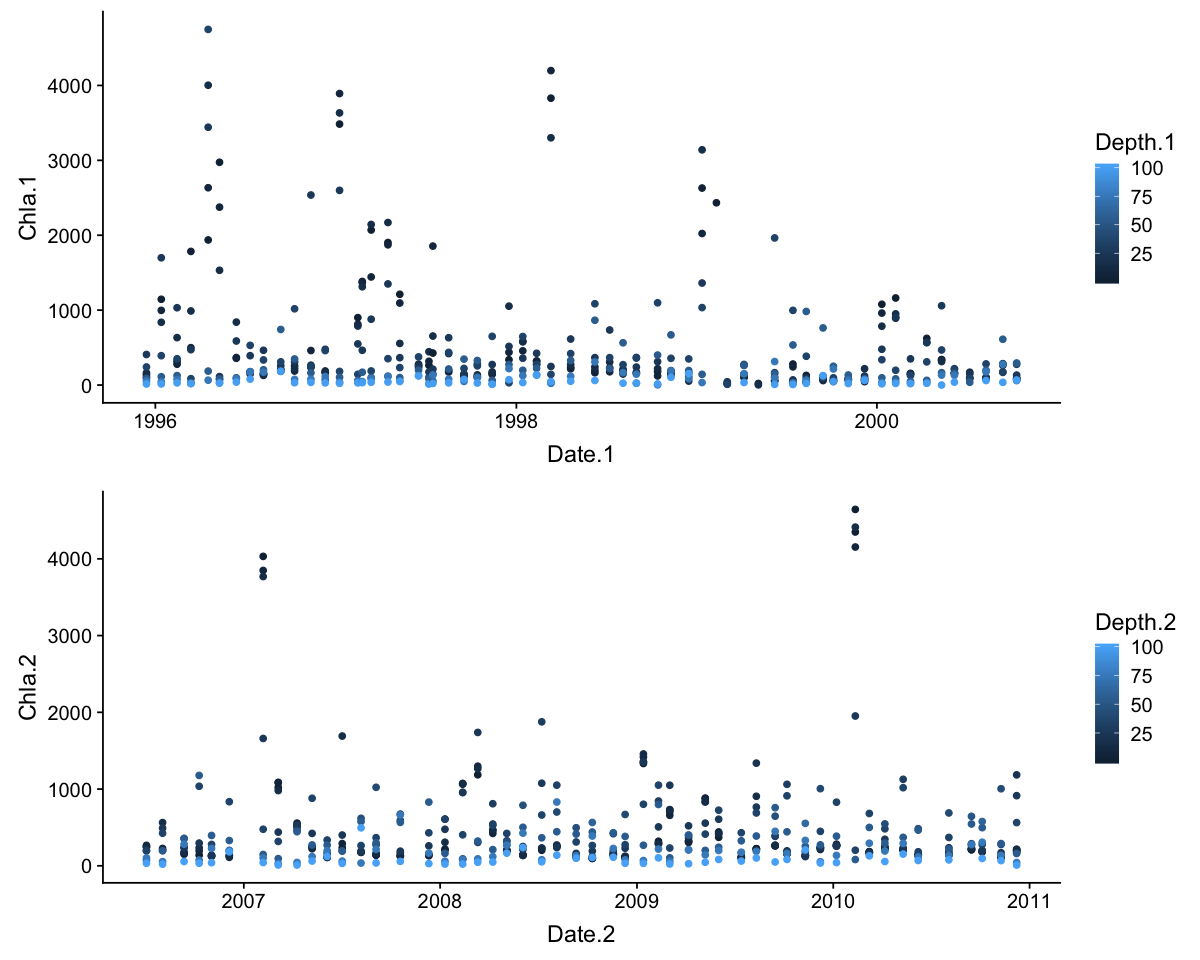

In [5]:
options(repr.plot.width=10, repr.plot.height=8)
a <- ggplot(data=TotChlA)+geom_point(aes(x=Date.1,y=Chla.1,col=Depth.1))
b <- ggplot(data=TotChlA)+geom_point(aes(x=Date.2,y=Chla.2,col=Depth.2))

plot_grid(a,b, ncol=1)

In [6]:
MLD <- read.csv("CARIACO Data for Mixed Layer Depth.csv")

In [7]:
MLD$date <- as.POSIXct(as.character(MLD$date), format="%m/%d/%y")

In [8]:
MLD <- MLD[complete.cases(MLD$MLD),]

In [9]:
tail(MLD)

,date,MLD
188,2012-05-15,33
189,2012-07-15,37
190,2012-08-15,15
191,2012-09-15,13
192,2012-10-15,12
193,2012-11-15,22


In [10]:
# function to prepare data frame for interpolation
#' 1. rename columns
prep_df_ntrplt <- function(dataframe){
  
  colnames(dataframe) <- c("date", "depth","var")
  
  return(dataframe)
}


# function to return interpolated data frame:
#' "The function mba.surf returns a surface approximated from a 
#' bivariate scatter of data points using multilevel B-splines."
ntrplt <-function(dataframe, res = 1000, extended=T){
  
  dataframe$date <- decimal_date(dataframe$date)

  mba <- mba.surf(dataframe[,c('date', 'depth', 'var')], no.X = res, no.Y = res, extend = extended, m = 3, h = 5)
  dimnames(mba$xyz.est$z) <- list(mba$xyz.est$x, mba$xyz.est$y)
  df3 <- melt(mba$xyz.est$z, varnames = c('date', 'depth'), value.name = 'var')

  return(df3)	
}


# function create oceanographic plot from interpolated data frame
#' it plots the original data points on top of the interpolated data 
plt.ocean <-function(df_int,dataframe){
  
  dataframe$date <- decimal_date(dataframe$date)
  
  Fig <-
    ggplot(data=df_int, aes(date, depth)) +
    
    geom_raster(aes(fill = var), interpolate = T, hjust = 0.5, vjust = 0.5) +
    #geom_contour(aes(z = var)) + 
    
    geom_point(data = dataframe, aes(date, depth), colour = 'white', alpha = 0.5) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_reverse(expand=c(0,0)) +
    scale_fill_gradientn(colours = matlab.like2(7))
  
  return(Fig)
}

In [11]:
chla1 <- data.frame("date" = TotChlA$Date.1, "press" = TotChlA$Depth.1, "chla" = TotChlA$Chla.1)[complete.cases(data.frame("date" = TotChlA$Date.1, "press" = TotChlA$Depth.1, "chla" = TotChlA$Chla.1)),] 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
“Removed 137 rows containing missing values (geom_path).”

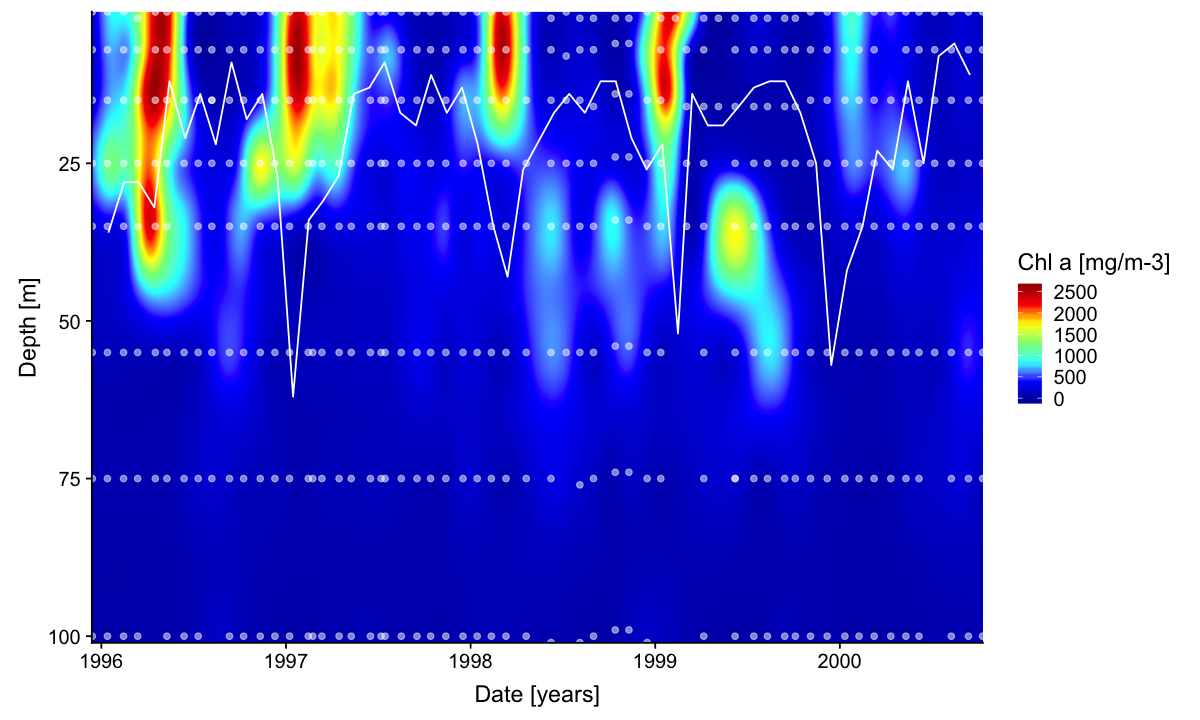

In [33]:
#PLOTS:
t1 <- prep_df_ntrplt(chla1)
t2 <- ntrplt(t1)
ft <- plt.ocean(t2,t1) + xlab('Date [years]') + ylab('Depth [m]') + labs(fill='Chl a [mg/m-3]') 
ft + geom_line(data = MLD, aes(y=MLD,x=decimal_date(date)), col='white')+ scale_x_continuous(limits=layer_scales(ft)$x$range$range, expand=c(0,0))

In [34]:
chla2 <- data.frame("date" = TotChlA$Date.2, "press" = TotChlA$Depth.2, "chla" = TotChlA$Chla.2)[complete.cases(data.frame("date" = TotChlA$Date.2, "press" = TotChlA$Depth.2, "chla" = TotChlA$Chla.2)),] 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
“Removed 142 rows containing missing values (geom_path).”

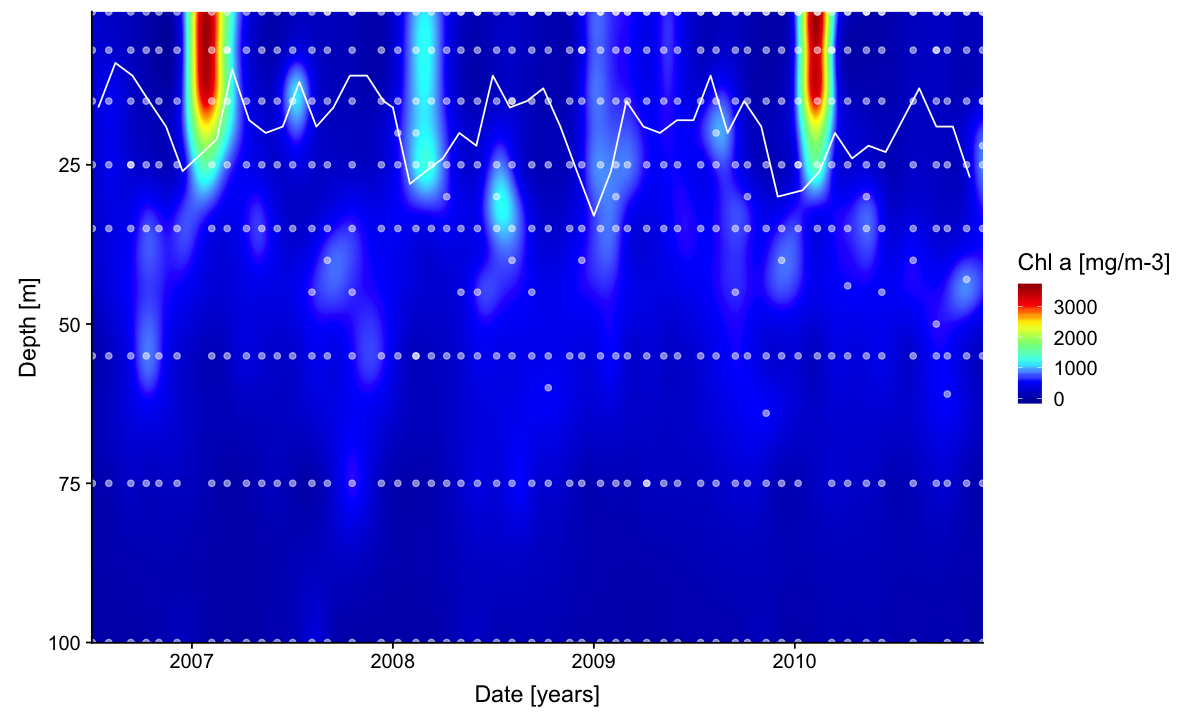

In [35]:
#PLOTS:
t1_2 <- prep_df_ntrplt(chla2)
t2_2 <- ntrplt(t1_2)
ft_2 <- plt.ocean(t2_2,t1_2) + xlab('Date [years]') + ylab('Depth [m]') + labs(fill='Chl a [mg/m-3]') 
ft_2 + geom_line(data = MLD, aes(y=MLD,x=decimal_date(date)), col='white')+ scale_x_continuous(limits=layer_scales(ft_2)$x$range$range, expand=c(0,0))

In [ ]:
head(chla1)

In [13]:
chla <- read.csv('chlor_a.csv')
head(chla)

date,min,max,mean,std,median
1997-09-04T00:00:00,0.1443579,0.2297113,0.1762109,0.04242001,0.1758632
1997-10-01T00:00:00,0.1395829,0.2422645,0.1782952,0.05974948,0.1722672
1997-11-01T00:00:00,0.2668941,0.7109126,0.3950535,0.10651325,0.3565871
1997-12-01T00:00:00,0.2611626,1.0160677,0.4397495,0.16024762,0.3573259
1998-01-01T00:00:00,0.2743728,1.4962558,0.6067422,0.23881455,0.4360563
1998-02-01T00:00:00,0.2703363,0.6841422,0.4014198,0.10076832,0.3820691


In [14]:
chla$Date <- as.Date(as.character(chla$date))

In [15]:
head(chla)

date,min,max,mean,std,median,Date
1997-09-04T00:00:00,0.1443579,0.2297113,0.1762109,0.04242001,0.1758632,1997-09-04
1997-10-01T00:00:00,0.1395829,0.2422645,0.1782952,0.05974948,0.1722672,1997-10-01
1997-11-01T00:00:00,0.2668941,0.7109126,0.3950535,0.10651325,0.3565871,1997-11-01
1997-12-01T00:00:00,0.2611626,1.0160677,0.4397495,0.16024762,0.3573259,1997-12-01
1998-01-01T00:00:00,0.2743728,1.4962558,0.6067422,0.23881455,0.4360563,1998-01-01
1998-02-01T00:00:00,0.2703363,0.6841422,0.4014198,0.10076832,0.3820691,1998-02-01


In [16]:
Reg1 <- chla[chla$Date < as.Date("2000-01-01"),]
Reg2 <- chla[chla$Date > as.Date("2006-06-01") & chla$Date < as.Date("2011-01-01") ,]

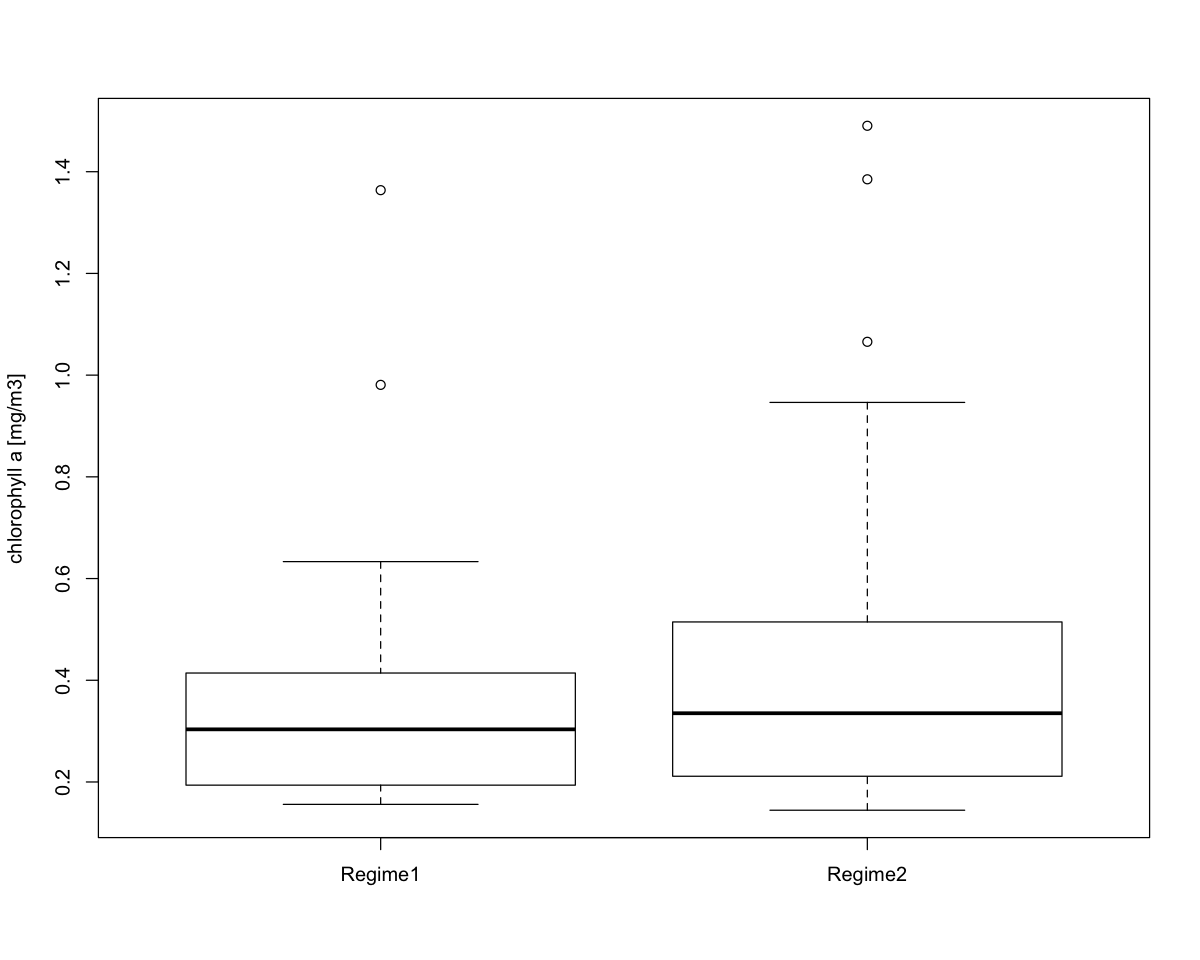

In [17]:
boxplot(Reg1$mean,Reg2$mean, ylab ='chlorophyll a [mg/m3]', names = c('Regime1', 'Regime2'))


In [18]:
FuncTypeChlA <- read.csv("CARIACO Data for Algal Group Plots.csv")

In [19]:
tail(FuncTypeChlA)

,Date,depth,Prasinophytes,Dinoflagellates,Cryptophytes,Haptophytes2,Chlorophytes,Cyanobacteria,Diatoms_Hapto1,Hapto3_Hapto4,X2Date,X2depth,X2Prasinophytes,X2Dinoflagellates,X2Cryptophytes,X2Haptophytes2,X2Chlorophytes,X2Cyanobacteria,X2Diatoms_Hapto1,X2Hapto3_Hapto4
444,,NA,NA,NA,NA,NA,NA,NA,NA,NA,12/08/10,15,10.04,15.82,12.06,14.24,9.51,46.51,61.81,42.02
445,,NA,NA,NA,NA,NA,NA,NA,NA,NA,12/08/10,25,21.27,10.19,88.71,153.82,37.58,40.87,283.85,277.71
446,,NA,NA,NA,NA,NA,NA,NA,NA,NA,12/08/10,35,19.86,12.10,75.96,93.06,4.81,26.02,81.08,250.10
447,,NA,NA,NA,NA,NA,NA,NA,NA,NA,12/08/10,55,47.75,14.34,6.07,23.94,0.38,8.43,7.29,51.80
448,,NA,NA,NA,NA,NA,NA,NA,NA,NA,12/08/10,75,6.69,2.04,5.03,5.12,7.10,1.76,4.88,9.39
449,,NA,NA,NA,NA,NA,NA,NA,NA,NA,12/08/10,100,0.00,1.20,2.62,0.40,3.48,0.69,0.78,0.83


In [20]:
FuncTypeChlA$Date <- as.POSIXct(as.character(FuncTypeChlA$Date), format="%m/%d/%y")
FuncTypeChlA$X2Date <- as.POSIXct(as.character(FuncTypeChlA$X2Date), format="%m/%d/%y")

Warning message:
“Removed 26 rows containing missing values (geom_point).”

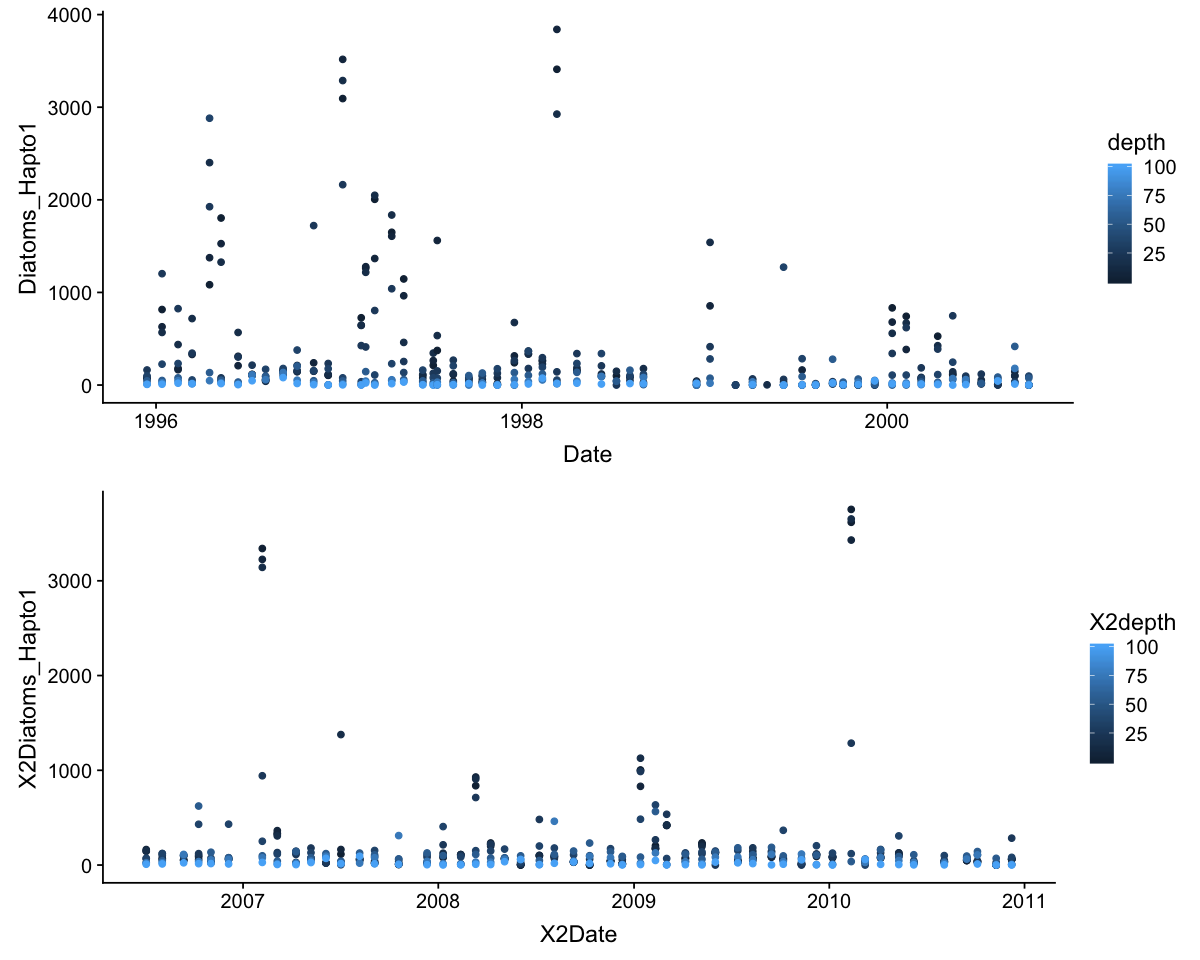

In [21]:
options(repr.plot.width=10, repr.plot.height=8)
a <- ggplot(data=FuncTypeChlA)+geom_point(aes(x=Date,y=Diatoms_Hapto1,col=depth))
b <- ggplot(data=FuncTypeChlA)+geom_point(aes(x=X2Date,y=X2Diatoms_Hapto1,col=X2depth))

plot_grid(a,b, ncol=1)

# TODO
what I want to analyze/plot:
- amount of Tot Chl a above and below MLD for both Regimes (also for all functional types)
- ranking of functional types according to abundance, AND according to cell size in integrated abundances
- biomass above MLD for most important functional types/groups as time series
    - this aggregated to model forcing!

In [429]:
# functions to interpolate and extract values above MLD from data frame
#' 1. rename data frame
prep_df_ntrplt <- function(dataframe){
    colnames(dataframe) <- c("date", "depth","var")
    return(dataframe)
}

#' 2. interpolate data frame
interpolate <- function(dataframe, intpltfunc="linear", depth_to=100, res=1){ 
    zz <- seq(0, depth_to, res)
    
    DF <- dataframe %>%
    select(date, var, depth) %>%
    gather(key='key',value = "value", -date, -depth)
    
    if(intpltfunc=="oce-rr"){
        DF_int <- DF %>%
        group_by(date) %>%
        do(data.frame(value_int = with(.,oceApprox(depth, value, zz, "rr")), depth = zz))}
    if(intpltfunc=="linear"){
        DF_int <- DF %>%
        group_by(date) %>%
        filter(sum(!is.na(value))>2) %>%
        filter(!is.na(depth)) %>%
        do(data.frame(value_int = with(.,approx(depth, value, zz, "linear", rule=2)), depth = zz))
        print('hello')
        names(DF_int)[names(DF_int) == 'value_int.y'] <- 'value_int'}
    else{
        DF_int <- DF
        print(names(DF_int))
        names(DF_int) <- c('date','depth','key','value_int')
        print(names(DF_int))
    }

    return(DF_int)
}

# PhyTotAbund_mean <- PhyTotAbundDF %>%
#    group_by(Date) %>%
#    filter(sum(!is.na(TotAbund))>=2) %>%
#    filter(!is.na(mld_depth)) %>%
#    do(data.frame( with(.,approx(depth, TotAbund, xout = seq(min(depth), max(mld_depth), by = 1), rule=2)), max(.$mld_depth), max(.$depth))) %>%
#    #ChlA_mean$y[is.na(ChlA_mean$y)] <- ChlA_mean$y[ChlA_mean$x == ChlA_mean$max...Depth_real.] 
#    summarize(meanPhyAbund = mean(y,na.rm=T), meanPhyAbundm2 = (mean(y,na.rm=T)/1e-6) * mean(max...mld_depth.))


#' 3. filter interpolated frame for values above MLD and return mean
filterMLD <- function(DF_int, MLDdf, above=T){ 
    
    DF_int$dateMY = format(as.Date(DF_int$date), "%Y-%m")
    MLDdf$dateMY  = format(as.Date(MLDdf$date), "%Y-%m")
    
    merge_DF_MLD <- merge(DF_int, MLDdf, by="dateMY")
    merge_DF_MLD$depthdiff <- merge_DF_MLD$MLD - merge_DF_MLD$depth
    
    if(above==T)
    {DF_filtered_MLD <- merge_DF_MLD %>%
    group_by(dateMY) %>% # this groups it by the run number 
    filter(depthdiff > 0) %>% # only keep values above MLD
    summarize(mean=mean(value_int, na.rm=T))
    
    merge_filtDF_MLD <- merge(DF_filtered_MLD, MLDdf, by="dateMY")
    merge_filtDF_MLD$depint_mean <- merge_filtDF_MLD$mean * merge_filtDF_MLD$MLD
    }
    if(above==F){
    DF_filtered_MLD <- merge_DF_MLD %>%
    group_by(dateMY) %>% # this groups it by the run number 
    filter(depthdiff < 0) %>% # only keep values below MLD
    summarize(mean=mean(value_int, na.rm=T))
    
    merge_filtDF_MLD <- merge(DF_filtered_MLD, MLDdf, by="dateMY")
    merge_filtDF_MLD$depint_mean <- merge_filtDF_MLD$mean * (100 - merge_filtDF_MLD$MLD)
    }
    if(above=='Full'){
    DF_filtered_MLD <- DF_int %>%
    group_by(dateMY) %>% # this groups it by the run number 
    # filter(depthdiff < 0) %>% # only keep values below MLD
    summarize(mean=mean(value_int, na.rm=T))
    
    merge_filtDF_MLD <- merge(DF_filtered_MLD, MLDdf, by="dateMY")
    merge_filtDF_MLD$depint_mean <- merge_filtDF_MLD$mean * 100
    }
    
    return(merge_filtDF_MLD)
 }

In [430]:
### df_1 <- prep_df_ntrplt(chla1)
head(df_1)
int_1 <- interpolate(df_1)
head(int_1)
mld_1 <- filterMLD(int_1, MLD)
mld_1_belo <- filterMLD(int_1, MLD, above = F)

mld_1$depint_mean <- mld_1$depint_mean / 1000
mld_1_belo$depint_mean <- mld_1_belo$depint_mean / 1000


head(df_1)
head(int_1)
head(mld_1)
nrow(mld_1)

date,depth,var
1995-12-14,1,107
1995-12-14,7,139
1995-12-14,15,163
1995-12-14,25,408
1995-12-14,35,241
1995-12-14,55,88


[1] "hello"


date,value_int.x,value_int,depth
1995-12-14,0,107.0000,0
1995-12-14,1,107.0000,1
1995-12-14,2,112.3333,2
1995-12-14,3,117.6667,3
1995-12-14,4,123.0000,4
1995-12-14,5,128.3333,5


date,depth,var
1995-12-14,1,107
1995-12-14,7,139
1995-12-14,15,163
1995-12-14,25,408
1995-12-14,35,241
1995-12-14,55,88


date,value_int.x,value_int,depth
1995-12-14,0,107.0000,0
1995-12-14,1,107.0000,1
1995-12-14,2,112.3333,2
1995-12-14,3,117.6667,3
1995-12-14,4,123.0000,4
1995-12-14,5,128.3333,5


dateMY,mean,date,MLD,depint_mean
1996-01,1078.3194,1996-01-15,36,38.81950
1996-02,593.0429,1996-02-15,28,16.60520
1996-03,874.5857,1996-03-15,28,24.48840
1996-04,3297.0969,1996-04-15,32,105.50710
1996-05,2511.8125,1996-05-15,12,30.14175
1996-06,559.6429,1996-06-15,21,11.75250


[1] 54

In [343]:
options(repr.plot.width=10, repr.plot.height=8) #FIX PLOT SIZE

In [234]:
reg1vs2abovevsbelo_totchla_1 <- ggplot() + geom_point(data=mld_1, aes(x=date,y=depint_mean, col='above MLD')) + 
    geom_point(data=mld_1_belo, aes(x=date,y=depint_mean, col='below MLD')) + xlab('') +
    ylab(expression(depth~int.~chl~a~'['~ng~m^{-3}~']'))

mld_1$col <- "above MLD"
mld_1_belo$col <- "below MLD"
mldcomb <- rbind(mld_1, mld_1_belo)

means <- aggregate(depint_mean ~  col, mldcomb, mean)

means$depint_mean <- round(means$depint_mean, digits = 2)
head(means)

outliersX_above <- length(which(mldcomb[mldcomb$col == 'above MLD',]$depint_mean > 25))
outliersX_below <- length(which(mldcomb[mldcomb$col == 'below MLD',]$depint_mean > 25))

outliers <- data.frame("outliers" = c(outliersX_above,outliersX_below), "col" = c("above MLD", "below MLD"))
outliers

totchlabox1 <- ggplot(data=mldcomb, aes(x=col ,y=depint_mean, col=col)) + geom_boxplot(show.legend = F) +  
    geom_point(data = means, aes(x = col, y = depint_mean, shape = 'mean'), col = 'black', show.legend = T) + 
    geom_text(data = means, aes(label = depint_mean, y = depint_mean, shape = 'mean'), col = 'black', nudge_x = 0.3, show.legend = F) +
    geom_text(data = outliers, aes(label = paste("n of out =",outliers), y = 24), show.legend = F) +
    guides(color = FALSE)+ scale_y_continuous(limits = c(0,25),expand=c(0,0))#+ theme(legend.title = element_blank())

col,depint_mean
above MLD,14.84
below MLD,4.16


outliers,col
11,above MLD
1,below MLD


Warning message:
“Ignoring unknown aesthetics: shape”

In [26]:
df_2 <- prep_df_ntrplt(chla2)

int_2 <- interpolate(df_2)

mld_2 <- filterMLD(int_2, MLD)
mld_2_belo <- filterMLD(int_2, MLD, above = F)

mld_2$depint_mean <- mld_2$depint_mean / 1000
mld_2_belo$depint_mean <- mld_2_belo$depint_mean / 1000

head(MLD)
nrow(MLD)
head(int_2)
nrow(int_2)
head(mld_2)
nrow(mld_2)

ERROR: Error in prep_df_ntrplt(chla2): object 'chla2' not found


In [27]:
reg1vs2abovevsbelo_totchla_2 <- ggplot() + geom_point(data=mld_2, aes(x=date,y=depint_mean, col='above MLD')) + 
    geom_point(data=mld_2_belo, aes(x=date,y=depint_mean, col='below MLD'))


mld_2$col <- "above MLD"
mld_2_belo$col <- "below MLD"
mld2comb <- rbind(mld_2, mld_2_belo)

means2 <- aggregate(depint_mean ~  col, mld2comb, mean)

means2$depint_mean <- round(means2$depint_mean, digits = 2)
head(means2)

outliersX2_above <- length(which(mld2comb[mld2comb$col == 'above MLD',]$depint_mean > 25))
outliersX2_below <- length(which(mld2comb[mld2comb$col == 'below MLD',]$depint_mean > 25))

outliers2 <- data.frame("outliers" = c(outliersX2_above,outliersX2_below), "col" = c("above MLD", "below MLD"))
outliers2
totchlabox2 <- ggplot(data=mld2comb, aes(x=col ,y=depint_mean, col=col)) + geom_boxplot(show.legend = F) +  
    geom_point(data = means2, aes(x = col, y = depint_mean, shape = 'mean'), col='black', show.legend = T) + 
    geom_text(data = means2, aes(label = depint_mean, y = depint_mean, shape = 'mean'), col='black', nudge_x = 0.3, show.legend = F) +
    geom_text(data = outliers2, aes(label = paste("n of out =",outliers), y = 24), show.legend = F) +
    guides(color = FALSE)+ scale_y_continuous(limits = c(0,25),expand=c(0,0)) + #+ theme(legend.title = element_blank()) +
    theme(axis.text.x = element_text(angle = -45, vjust = 0, hjust=0))

ERROR: Error in fortify(data): object 'mld_2' not found


In [28]:
title1 <- ggdraw() + draw_label("Total integrated chl a above & below MLD")#, fontface='bold')

In [29]:
plots1_1 <- reg1vs2abovevsbelo_totchla_1+ theme(legend.position="none")+ ylab("") + ylim(0,120) + ylab(expression('['~ng~m^{-3}~']'))
plots1_2 <- reg1vs2abovevsbelo_totchla_2+ theme(legend.position="none")+ ylab("") + ylim(0,120) + ylab(expression(depth~int.~chl~a~'['~ng~m^{-3}~']'))

# ncol=1, labels=c('regime 1','regime 2'), hjust = -1.2, vjust = 1, align = 'h')

plots2_1 <- totchlabox1 + 
                    theme(legend.position="none", axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())+ 
                    ylab("") + xlab("") #+ scale_y_log10()

plots2_2 <- totchlabox2 + 
                    theme(legend.position="none", axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())+ 
                    ylab("") + xlab("") #+ scale_y_log10(limits = c(1, 100), breaks=c(0,1,5,10,25,50,100)) #, ncol = 1)


labels1 <- plot_grid(get_legend(reg1vs2abovevsbelo_totchla_1), get_legend(totchlabox1), ncol = 1)

plots1_2 <- plot_grid(plots1_1, plots2_1, labels1, plots1_2, plots2_2, align='vh', ncol=3, rel_widths =c(5,3,1))

plot_grid(title1, plots1_2, ncol=1, rel_heights=c(0.1, 1.5))

ERROR: Error in eval(expr, envir, enclos): object 'reg1vs2abovevsbelo_totchla_2' not found


In [431]:
# aux function for plotting the boxplots, used in "plotabovebelow" function
plotABboxplot <- function(mld, mld_belo, ylimboxplot){ 
    mld$col <- "above MLD"
    mld_belo$col <- "below MLD"
    mldcomb <- rbind(mld, mld_belo)

    means <- aggregate(depint_mean ~  col, mldcomb, mean)
    means$depint_mean <- round(means$depint_mean, digits = 2)

    outliers_above <- length(which(mldcomb[mldcomb$col == 'above MLD',]$depint_mean > ylimboxplot))
    outliers_below <- length(which(mldcomb[mldcomb$col == 'below MLD',]$depint_mean > ylimboxplot))

    outliers <- data.frame("outliers" = c(outliers_above, outliers_below), "col" = c("above MLD", "below MLD"))

    boxplot <- ggplot(data=mldcomb, aes(x=col ,y=depint_mean, col=col)) + geom_boxplot(show.legend = F) +  
        geom_point(data = means, aes(x = col, y = depint_mean, shape = 'mean'), col = 'black', show.legend = T) + 
        geom_text(data = means, aes(label = depint_mean, y = depint_mean), col = 'black', nudge_x = 0.3, show.legend = F) +
        geom_text(data = outliers, aes(label = paste("n of out =",outliers), y = ylimboxplot-ylimboxplot/20), show.legend = F) +
        guides(color = FALSE)+ scale_y_continuous(limits = c(0,ylimboxplot),expand=c(0,0))
    
    return(boxplot)}

#TOTAL (100 meter) INTEGRATED BOXPLOT
plotREGboxplot <- function(reg1, reg2, ylimboxplot){ 
    reg1$col <- "regime 1"
    reg2$col <- "regime 2"
    regcomb <- rbind(reg1, reg2)

    means <- aggregate(depint_mean ~  col, regcomb, mean)
    means$depint_mean <- round(means$depint_mean, digits = 2)
    
    outliers_reg1 <- length(which(reg1$depint_mean > ylimboxplot))
    outliers_reg2 <- length(which(reg2$depint_mean > ylimboxplot))
    
    outliers <- data.frame("outliers" = c(outliers_reg1, outliers_reg2), "col" = c("regime 1", "regime 2"))
    regcomb$col <- factor(regcomb$col, levels = c("regime 2","regime 1"),ordered = TRUE)
    
    boxplot <- ggplot(data=regcomb, aes(x=col ,y=depint_mean)) + geom_boxplot(show.legend = F) +  
        geom_point(data = means, aes(x=col, y=depint_mean, shape='mean'), col='red', show.legend = T) + 
        geom_text(data = means, aes(label = depint_mean, y = depint_mean), col='red', nudge_x = -0.1, show.legend = F) +
        geom_text(data = outliers, aes(label = paste("n of out =",outliers), y=ylimboxplot-ylimboxplot/5), show.legend = F, nudge_x = 0.3) +
        guides(color = FALSE)+ scale_y_continuous(limits = c(0,ylimboxplot),expand=c(0,0))
    
    return(boxplot)}

#' 4. plot above vs below MLD for each individual 
plotabovebelow <- function(int_1, int_2, MLD, unit="chl a", ylimboxplot=50, ylimtimeseries=120, title='placeholder'){ 
    # first filter interpolated data frames
    mld_1 <- filterMLD(int_1, MLD)
    mld_1_belo <- filterMLD(int_1, MLD, above = F)
    full_1 <- filterMLD(int_1, MLD, above = 'Full')
    
    mld_2 <- filterMLD(int_2, MLD)
    mld_2_belo <- filterMLD(int_2, MLD, above = F)
    full_2 <- filterMLD(int_2, MLD, above = 'Full')
    
    # convert mean to correct integrated units
    if(unit == "chl a"){
        mld_1$depint_mean <- mld_1$depint_mean / 1000
        mld_1_belo$depint_mean <- mld_1_belo$depint_mean / 1000
        
        mld_2$depint_mean <- mld_2$depint_mean / 1000
        mld_2_belo$depint_mean <- mld_2_belo$depint_mean / 1000
        
        full_1$depint_mean <- full_1$depint_mean / 1000
        full_2$depint_mean <- full_2$depint_mean / 1000
        }
    
    # create time series plots
    #1
    timeseries_1 <- ggplot() + geom_point(data=mld_1, aes(x=date,y=depint_mean, col='above MLD')) + 
    geom_point(data=mld_1_belo, aes(x=date,y=depint_mean, col='below MLD')) + xlab('') +
    ylab(expression(depth~int.~chl~a~'['~ng~m^{-2}~']')) + scale_x_datetime(date_breaks='1 year', date_labels ='%y')
    #2
    timeseries_2 <- ggplot() + geom_point(data=mld_2, aes(x=date,y=depint_mean, col='above MLD')) + 
    geom_point(data=mld_2_belo, aes(x=date,y=depint_mean, col='below MLD')) + scale_x_datetime(date_breaks='1 year', date_labels ='%y')

    
    # create boxplots
    #1
    boxplot_1 <- plotABboxplot(mld_1, mld_1_belo, ylimboxplot)
    #2
    boxplot_2 <- plotABboxplot(mld_2, mld_2_belo, ylimboxplot)
    
    # set title
    title1 <- ggdraw() + draw_label(paste("Total integrated", unit, "above & below MLD"))
    
    ts_1 <- timeseries_1 + theme(legend.position="none") + ylab("") + ylim(0,ylimtimeseries) + ylab(expression('['~mg~m^{-2}~']'))
    ts_2 <- timeseries_2 + theme(legend.position="none") + ylab("") + ylim(0,ylimtimeseries) + 
                ylab(expression(depth~int.~chl~a~'['~mg~m^{-2}~']')) + xlab('time [year]')

    # ncol=1, labels=c('regime 1','regime 2'), hjust = -1.2, vjust = 1, align = 'h')

    bx_1 <- boxplot_1 + 
                    theme(legend.position="none", axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())+ 
                    ylab("") + xlab("") 

    bx_2 <- boxplot_2 + 
                    theme(legend.position="none", axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())+ 
                    ylab("") + xlab("")
    
    vertregcomp <- plotREGboxplot(full_1, full_2, ylimboxplot) + xlab('') + ylab(expression('['~mg~m^{-2}~']')) + coord_flip()
    

    labels1 <- plot_grid(get_legend(timeseries_1), get_legend(boxplot_1), ncol = 1)

    plots <- plot_grid(ts_1, bx_1, labels1, ts_2, bx_2, labels1, vertregcomp, align='vh', ncol=3, rel_widths =c(5,3,1), hjust=-1.5 ,labels=c('regime 1','','','regime 2',''))

    return(plot_grid(title1, plots, ncol=1, rel_heights=c(0.1, 1.5), labels=c(paste(title),'')))
    }

[1] "hello"
[1] "hello"


Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

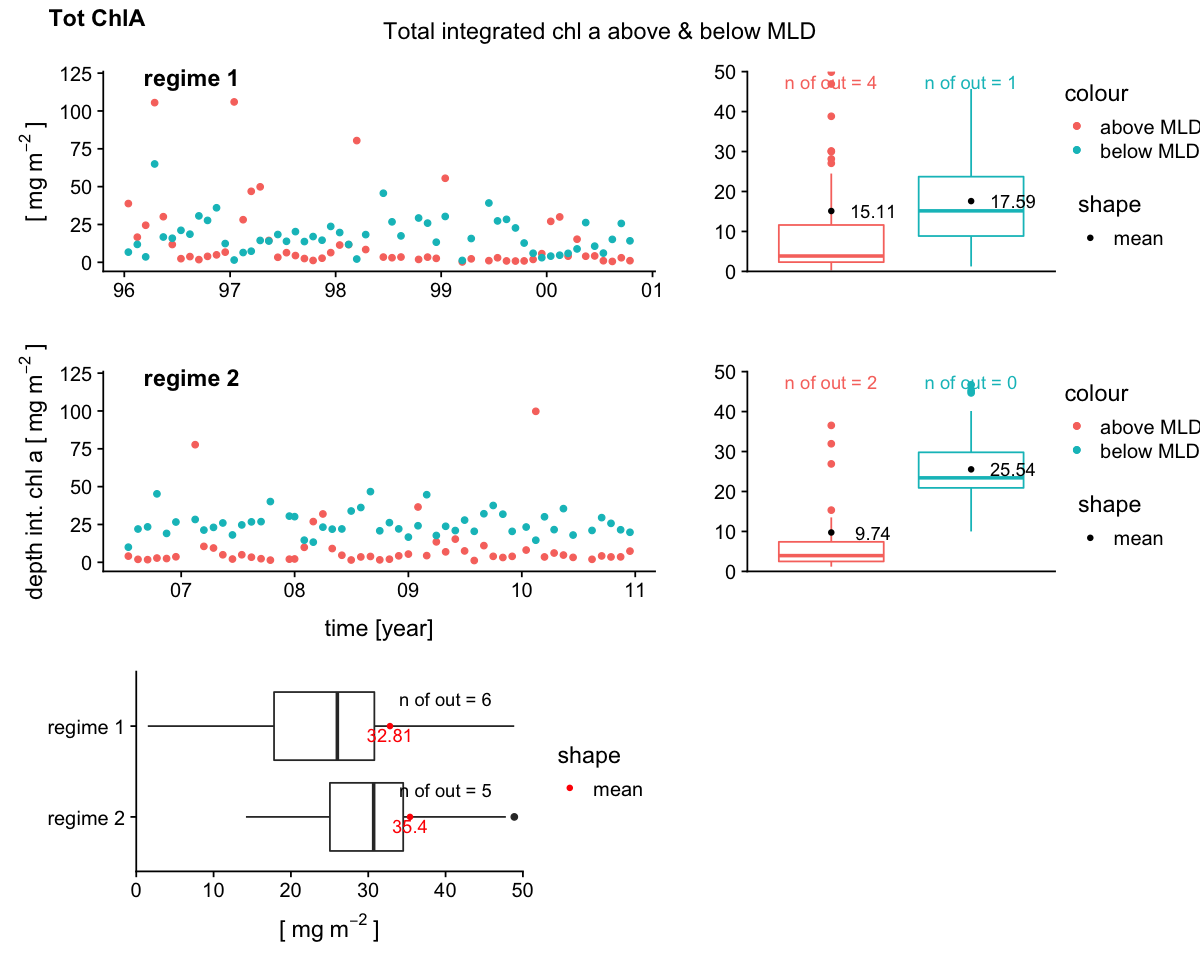

In [432]:
chla1 <- data.frame("date" = TotChlA$Date.1, "press" = TotChlA$Depth.1, 
                    "chla" = TotChlA$Chla.1)[complete.cases(data.frame(
                    "date" = TotChlA$Date.1, "press" = TotChlA$Depth.1, "chla" = TotChlA$Chla.1)),] 
chla2 <- data.frame("date" = TotChlA$Date.2, "press" = TotChlA$Depth.2, 
                    "chla" = TotChlA$Chla.2)[complete.cases(data.frame(
                    "date" = TotChlA$Date.2, "press" = TotChlA$Depth.2, "chla" = TotChlA$Chla.2)),] 

df_1 <- prep_df_ntrplt(chla1)
int_1 <- interpolate(df_1)

df_2 <- prep_df_ntrplt(chla2)
int_2 <- interpolate(df_2)

plotabovebelow(int_1,int_2,MLD, title="Tot ChlA")

In [433]:
mean(FuncTypeChlA$Diatoms_Hapto1, na.rm=T)
mean(FuncTypeChlA$X2Diatoms_Hapto1, na.rm=T)

[1] 255.6486

[1] 163.4619

[1] "hello"
[1] "hello"


Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

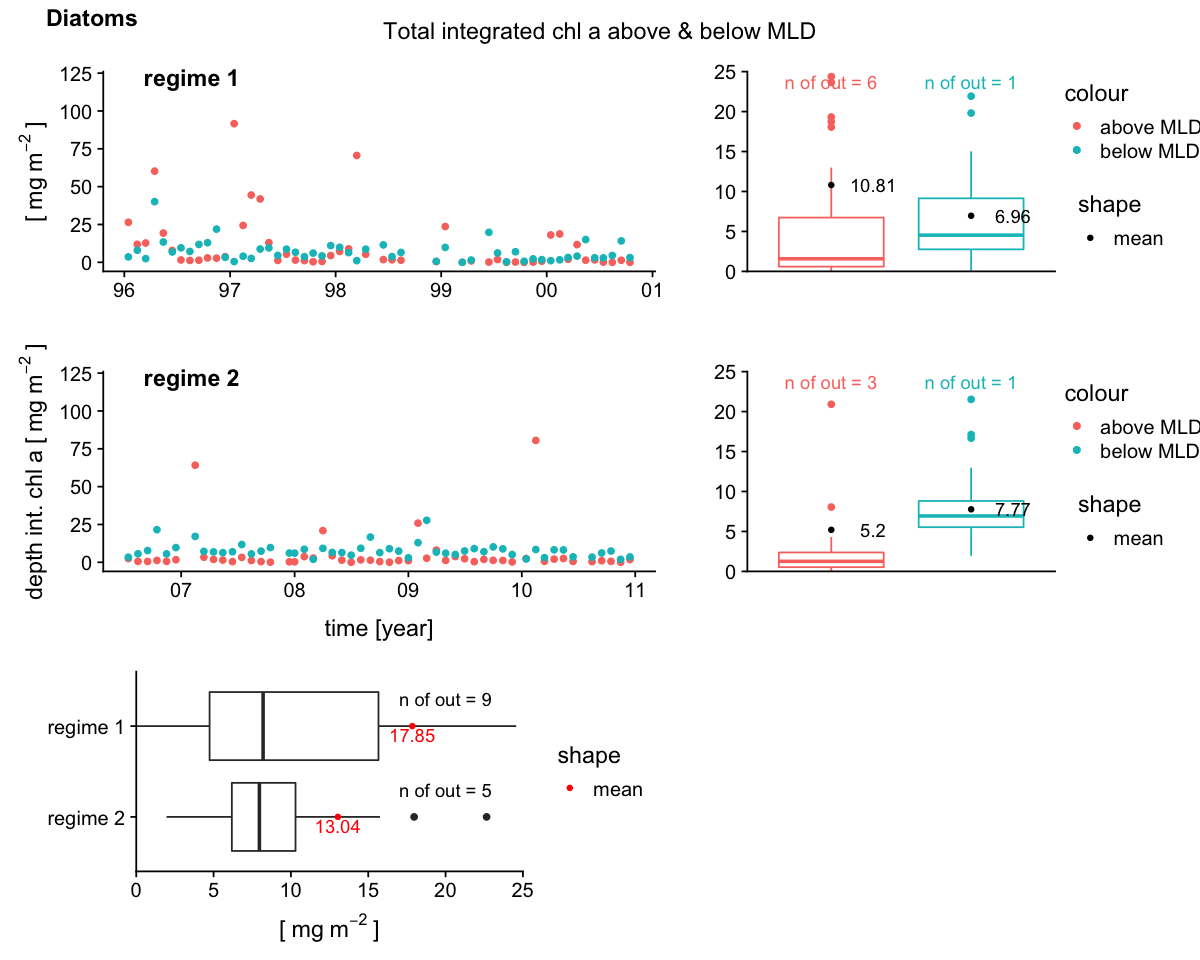

In [437]:
# FuncTypeChlA)+geom_point(aes(x=Date,y=Diatoms_Hapto1,col=depth))
# FuncTypeChlA)+geom_point(aes(x=X2Date,y=X2Diatoms_Hapto1,col=X2depth))
                                                                                                                                   
diatom_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Diatoms_Hapto1)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Diatoms_Hapto1)),] 
diatom_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Diatoms_Hapto1)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Diatoms_Hapto1)),] 

diatom_df_1 <- prep_df_ntrplt(diatom_chla1)
diatom_int_1 <- interpolate(diatom_df_1)

diatom_df_2 <- prep_df_ntrplt(diatom_chla2)
diatom_int_2 <- interpolate(diatom_df_2)

plotabovebelow(diatom_int_1,diatom_int_2,MLD, ylimboxplot = 25, title="Diatoms")

In [396]:
names(FuncTypeChlA)

[1] "Date"              "depth"             "Prasinophytes"    
 [4] "Dinoflagellates"   "Cryptophytes"      "Haptophytes2"     
 [7] "Chlorophytes"      "Cyanobacteria"     "Diatoms_Hapto1"   
[10] "Hapto3_Hapto4"     "X2Date"            "X2depth"          
[13] "X2Prasinophytes"   "X2Dinoflagellates" "X2Cryptophytes"   
[16] "X2Haptophytes2"    "X2Chlorophytes"    "X2Cyanobacteria"  
[19] "X2Diatoms_Hapto1"  "X2Hapto3_Hapto4"

[1] "hello"


,date,depth,var
444,2010-12-08,15,42.02
445,2010-12-08,25,277.71
446,2010-12-08,35,250.10
447,2010-12-08,55,51.80
448,2010-12-08,75,9.39
449,2010-12-08,100,0.83


[1] "hello"


Warning message:
“Removed 9 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 9 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 21 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

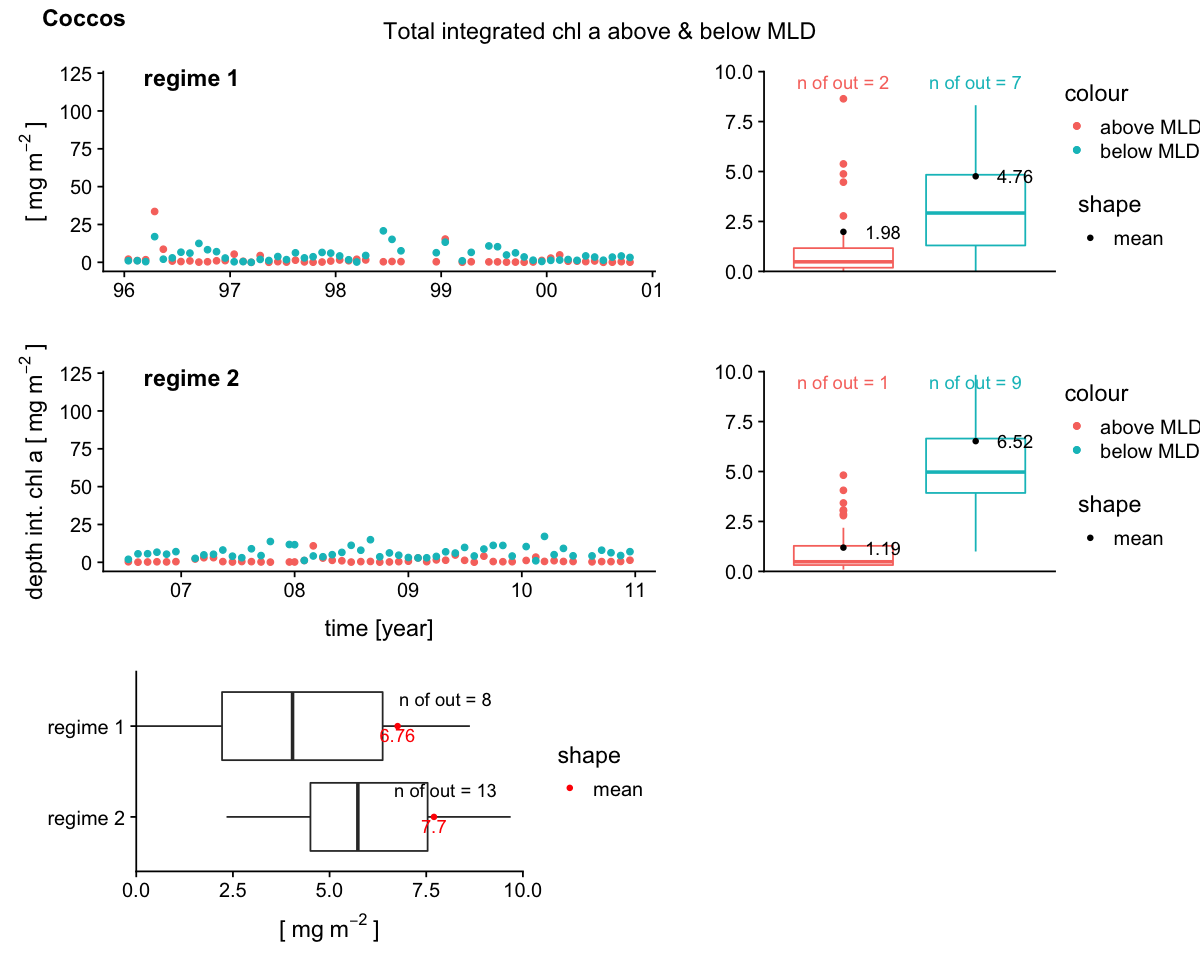

In [428]:
# FuncTypeChlA)+geom_point(aes(x=Date,y=Diatoms_Hapto1,col=depth))
# FuncTypeChlA)+geom_point(aes(x=X2Date,y=X2Diatoms_Hapto1,col=X2depth))
                                                                                                                                   
cocco_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Hapto3_Hapto4)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Hapto3_Hapto4)),] 
cocco_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Hapto3_Hapto4)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Hapto3_Hapto4)),] 

cocco_df_1 <- prep_df_ntrplt(cocco_chla1)
cocco_int_1 <- interpolate(cocco_df_1)

cocco_df_2 <- prep_df_ntrplt(cocco_chla2)
tail(cocco_df_2)
cocco_int_2 <- interpolate(cocco_df_2)

plotabovebelow(cocco_int_1,cocco_int_2,MLD, ylimboxplot = 10, title="Coccos")

[1] "hello"
[1] "hello"


Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 30 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

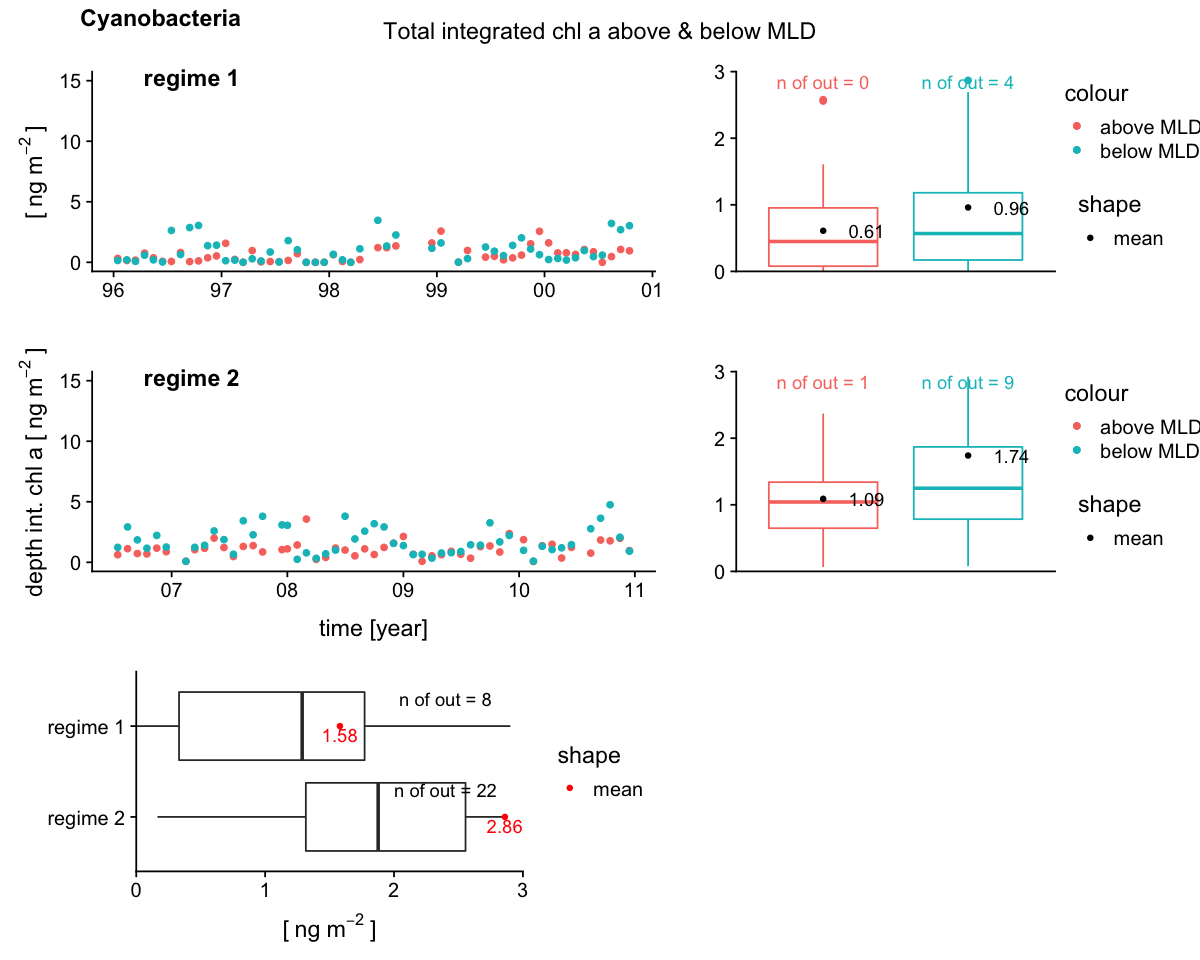

In [398]:
# FuncTypeChlA)+geom_point(aes(x=Date,y=Diatoms_Hapto1,col=depth))
# FuncTypeChlA)+geom_point(aes(x=X2Date,y=X2Diatoms_Hapto1,col=X2depth))
                                                                                                                                   
cyano_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Cyanobacteria)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Cyanobacteria)),] 
cyano_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Cyanobacteria)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Cyanobacteria)),] 

cyano_df_1 <- prep_df_ntrplt(cyano_chla1)
cyano_int_1 <- interpolate(cyano_df_1)

cyano_df_2 <- prep_df_ntrplt(cyano_chla2)
cyano_int_2 <- interpolate(cyano_df_2)

plotabovebelow(cyano_int_1,cyano_int_2,MLD, ylimtimeseries = 15, ylimboxplot = 3, title="Cyanobacteria")

[1] "hello"
[1] "hello"


Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 33 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

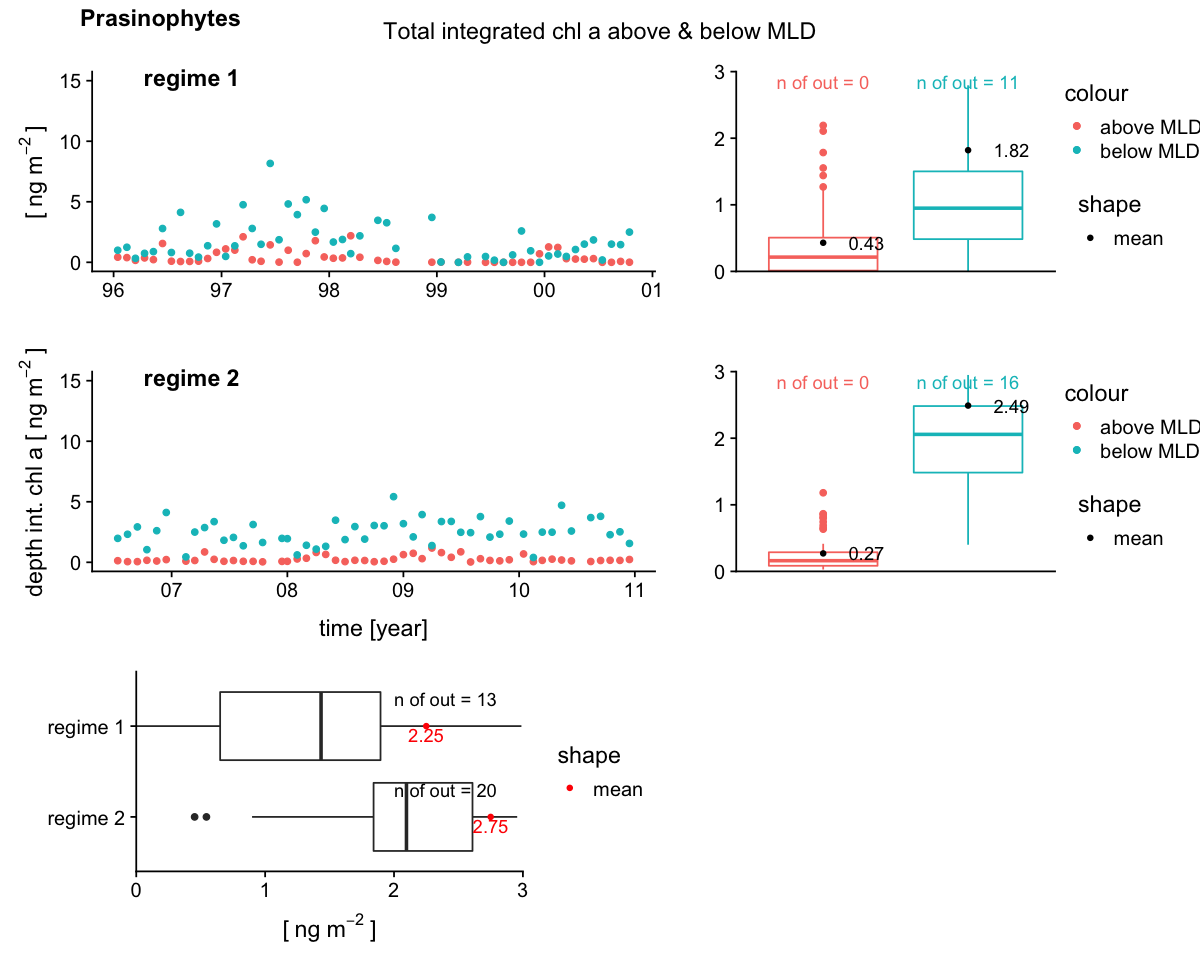

In [399]:
# Prasinophytes
                                                                                                                                   
prasi_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Prasinophytes)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Prasinophytes)),] 
prasi_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Prasinophytes)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Prasinophytes)),] 

prasi_df_1 <- prep_df_ntrplt(prasi_chla1)
prasi_int_1 <- interpolate(prasi_df_1)

prasi_df_2 <- prep_df_ntrplt(prasi_chla2)
prasi_int_2 <- interpolate(prasi_df_2)

plotabovebelow(prasi_int_1, prasi_int_2, MLD, ylimtimeseries = 15, ylimboxplot = 3, title="Prasinophytes")

[1] "hello"
[1] "hello"


Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

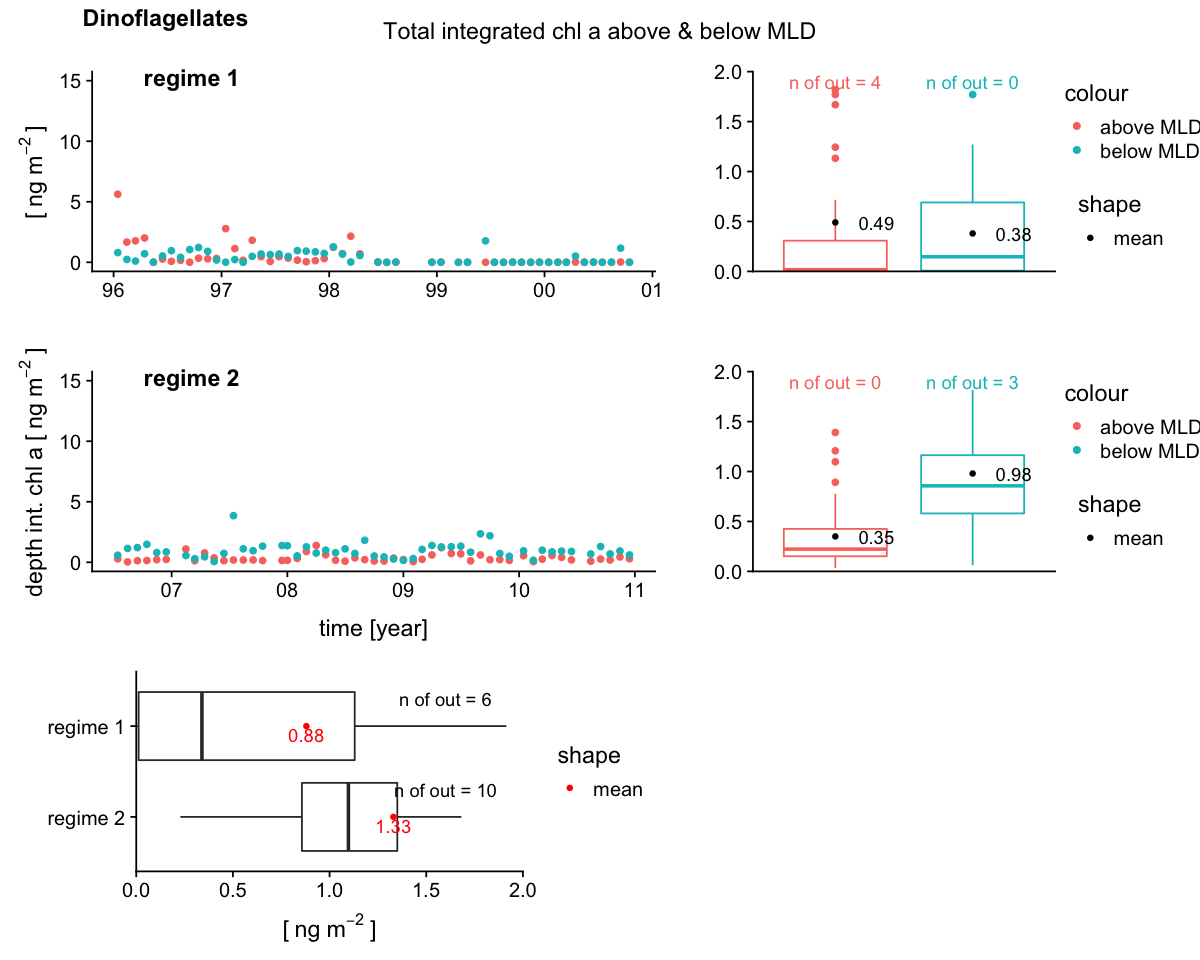

In [400]:
# Dinoflagellates
                                                                                                                                   
dino_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Dinoflagellates)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Dinoflagellates)),] 

dino_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Dinoflagellates)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Dinoflagellates)),] 

dino_df_1 <- prep_df_ntrplt(dino_chla1)
dino_int_1 <- interpolate(dino_df_1)

dino_df_2 <- prep_df_ntrplt(dino_chla2)
dino_int_2 <- interpolate(dino_df_2)

plotabovebelow(dino_int_1, dino_int_2, MLD,ylimtimeseries = 15, ylimboxplot = 2, title="Dinoflagellates")

[1] "hello"
[1] "hello"


Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 21 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

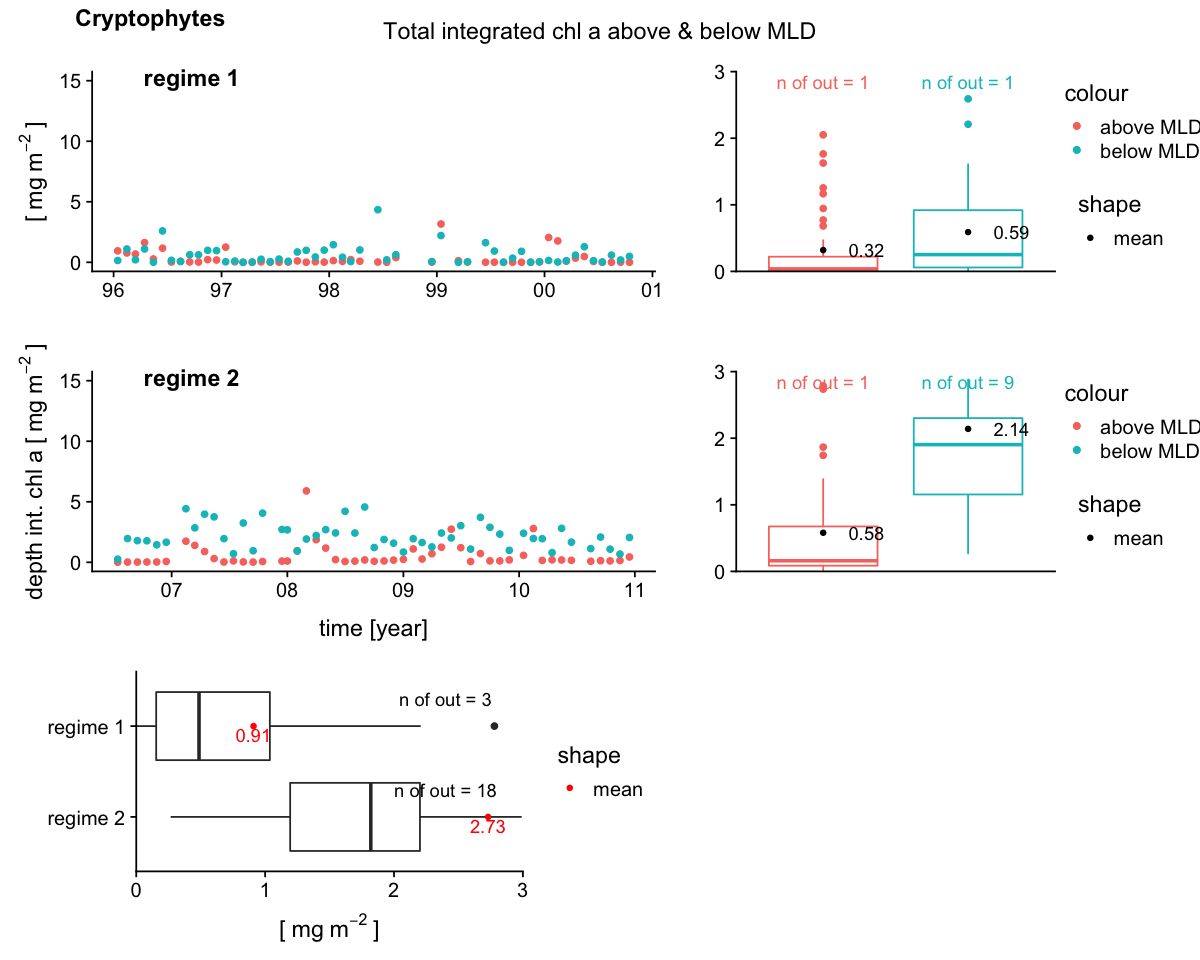

In [436]:
# Cryptophytes
                                                                                                                                   
crypto_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Cryptophytes)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Cryptophytes)),] 

crypto_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Cryptophytes)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Cryptophytes)),] 

crypto_df_1 <- prep_df_ntrplt(crypto_chla1)
crypto_int_1 <- interpolate(crypto_df_1)

crypto_df_2 <- prep_df_ntrplt(crypto_chla2)
crypto_int_2 <- interpolate(crypto_df_2)

plotabovebelow(crypto_int_1, crypto_int_2, MLD,ylimtimeseries = 15, ylimboxplot = 3, title="Cryptophytes")

[1] "hello"
[1] "hello"


Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

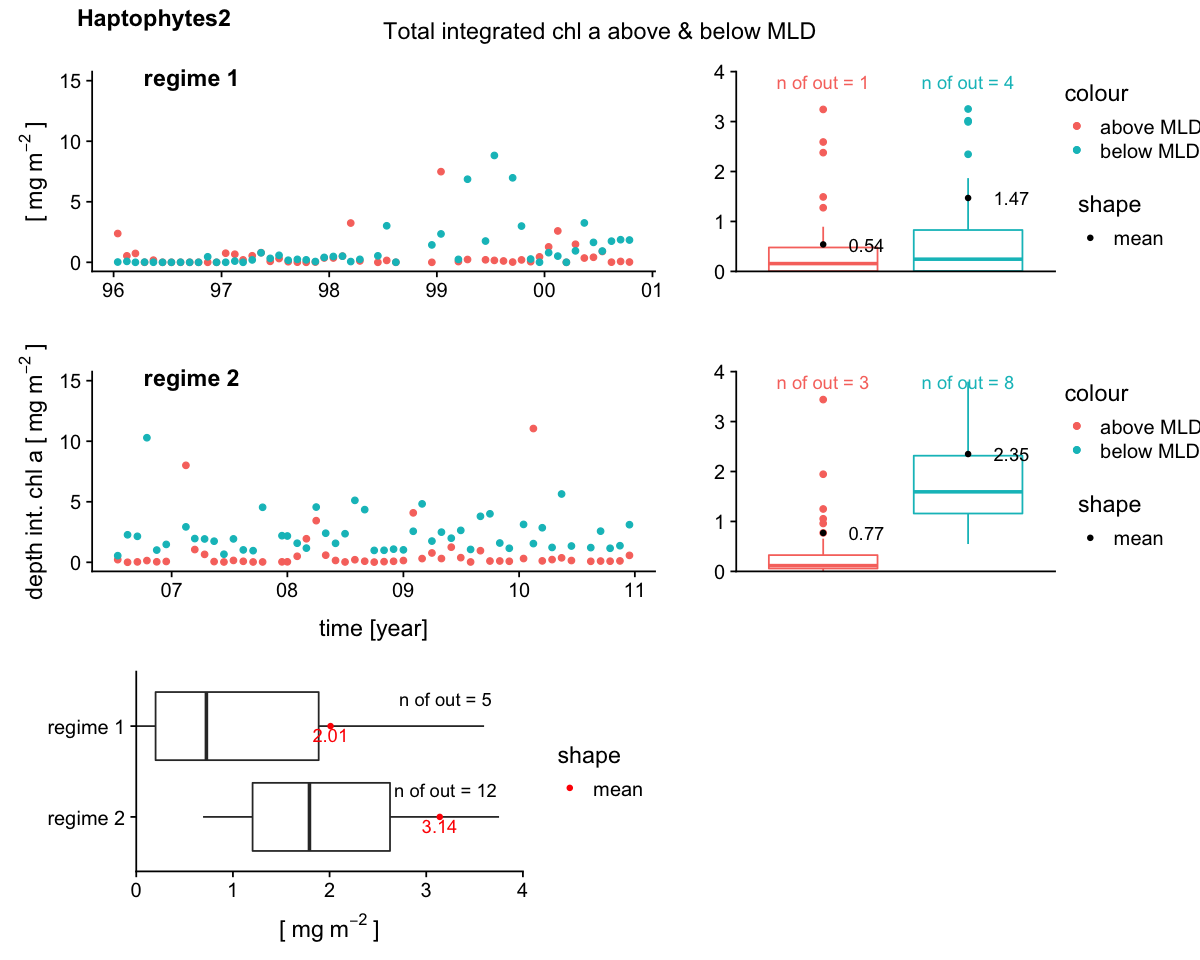

In [435]:
# Haptophytes2
                                                                                                                                   
hapto2_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Haptophytes2)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Haptophytes2)),] 

hapto2_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Haptophytes2)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Haptophytes2)),] 

hapto2_df_1 <- prep_df_ntrplt(hapto2_chla1)
hapto2_int_1 <- interpolate(hapto2_df_1)

hapto2_df_2 <- prep_df_ntrplt(hapto2_chla2)
hapto2_int_2 <- interpolate(hapto2_df_2)

plotabovebelow(hapto2_int_1, hapto2_int_2, MLD, ylimtimeseries = 15, ylimboxplot = 4, title="Haptophytes2")

[1] "hello"
[1] "hello"


Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”Warning message in align_plots(plotlist = plots, align = align, axis = axis):
“Complex graphs cannot be vertically aligned unless axis parameter is set properly. Placing graphs unaligned.”

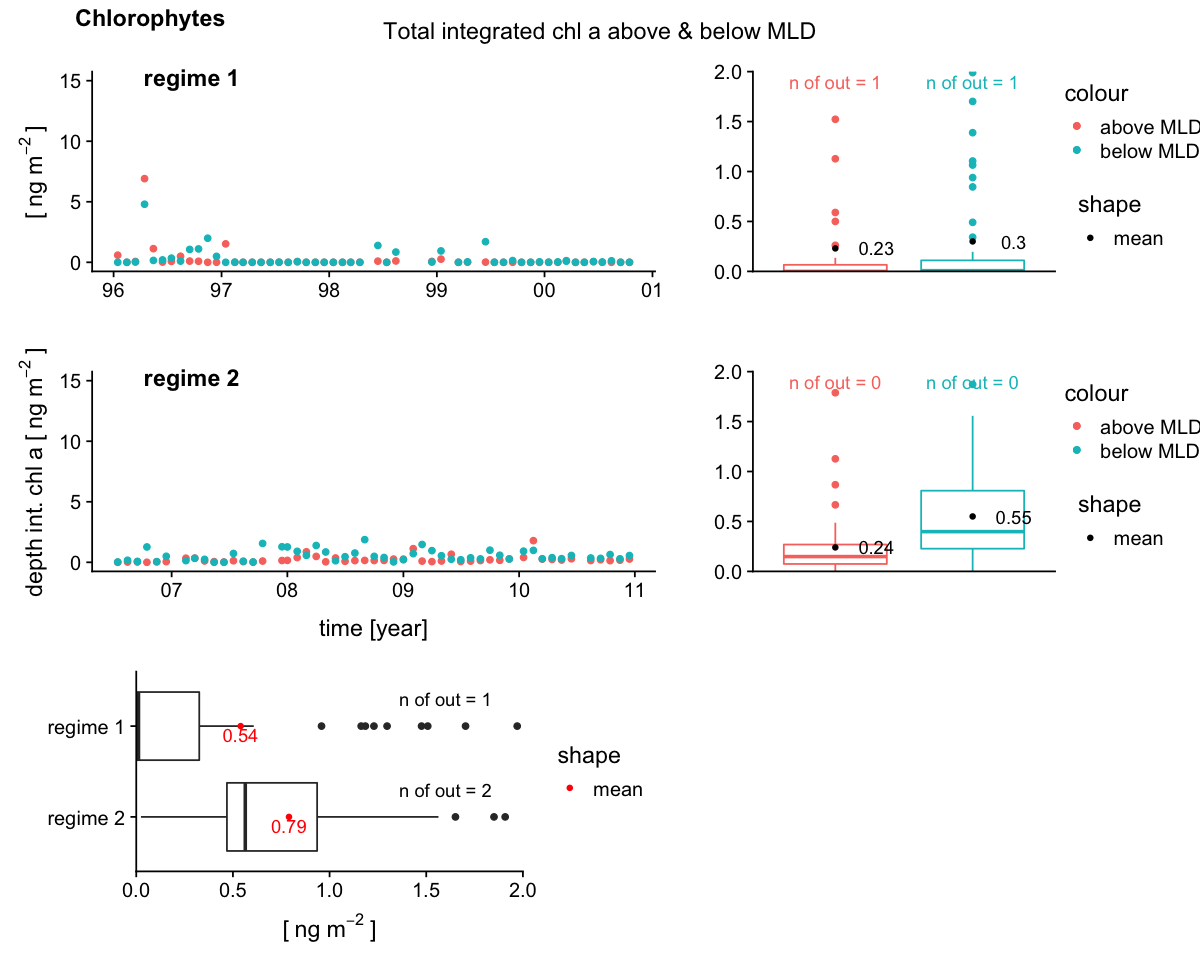

In [403]:
# Chlorophytes
                                                                                                                                   
chloro_chla1 <- data.frame("date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, 
                    "chla" = FuncTypeChlA$Chlorophytes)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$Date, "press" = FuncTypeChlA$depth, "chla" = FuncTypeChlA$Chlorophytes)),] 

chloro_chla2 <- data.frame("date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, 
                    "chla" = FuncTypeChlA$X2Chlorophytes)[complete.cases(data.frame(
                    "date" = FuncTypeChlA$X2Date, "press" = FuncTypeChlA$X2depth, "chla" = FuncTypeChlA$X2Chlorophytes)),] 

chloro_df_1 <- prep_df_ntrplt(chloro_chla1)
chloro_int_1 <- interpolate(chloro_df_1)

chloro_df_2 <- prep_df_ntrplt(chloro_chla2)
chloro_int_2 <- interpolate(chloro_df_2)

plotabovebelow(chloro_int_1, chloro_int_2, MLD, ylimtimeseries = 15, ylimboxplot = 2, title="Chlorophytes")

In [413]:
##### SOOOOOOO; NOW THE regime comparison for all!
hapto2_1 <- filterMLD(hapto2_int_1, MLD, above = 'Full')
hapto2_2 <- filterMLD(hapto2_int_2, MLD, above = 'Full')
hapto2_1$col <- "regime 1"
hapto2_2$col <- "regime 2"
hapto2_1$spec <- "hapto2"
hapto2_2$spec <- "hapto2"

chloro_1 <- filterMLD(chloro_int_1, MLD, above = 'Full')
chloro_2 <- filterMLD(chloro_int_2, MLD, above = 'Full')
chloro_1$col <- "regime 1"
chloro_2$col <- "regime 2"
chloro_1$spec <- "chloro"
chloro_2$spec <- "chloro"

dino_1 <- filterMLD(dino_int_1, MLD, above = 'Full')
dino_2 <- filterMLD(dino_int_2, MLD, above = 'Full')
dino_1$col <- "regime 1"
dino_2$col <- "regime 2"
dino_1$spec <- "dino"
dino_2$spec <- "dino"

crypto_1 <- filterMLD(crypto_int_1, MLD, above = 'Full')
crypto_2 <- filterMLD(crypto_int_2, MLD, above = 'Full')
crypto_1$col <- "regime 1"
crypto_2$col <- "regime 2"
crypto_1$spec <- "crypto"
crypto_2$spec <- "crypto"

prasi_1 <- filterMLD(prasi_int_1, MLD, above = 'Full')
prasi_2 <- filterMLD(prasi_int_2, MLD, above = 'Full')
prasi_1$col <- "regime 1"
prasi_2$col <- "regime 2"
prasi_1$spec <- "prasi"
prasi_2$spec <- "prasi"

cyano_1 <- filterMLD(cyano_int_1, MLD, above = 'Full')
cyano_2 <- filterMLD(cyano_int_2, MLD, above = 'Full')
cyano_1$col <- "regime 1"
cyano_2$col <- "regime 2"
cyano_1$spec <- "cyano"
cyano_2$spec <- "cyano"

cocco_1 <- filterMLD(cocco_int_1, MLD, above = 'Full')
cocco_2 <- filterMLD(cocco_int_2, MLD, above = 'Full')
cocco_1$col <- "regime 1"
cocco_2$col <- "regime 2"
cocco_1$spec <- "cocco"
cocco_2$spec <- "cocco"

diatom_1 <- filterMLD(diatom_int_1, MLD, above = 'Full')
diatom_2 <- filterMLD(diatom_int_2, MLD, above = 'Full')
diatom_1$col <- "regime 1"
diatom_2$col <- "regime 2"
diatom_1$spec <- "diatom"
diatom_2$spec <- "diatom"

FT_DataFrame <- rbind(hapto2_1,hapto2_2,chloro_1,chloro_2,dino_1,dino_2,crypto_1,crypto_2,prasi_1,prasi_2,cyano_1,cyano_2,cocco_1,cocco_2,diatom_1,diatom_2)

In [414]:
FT_DataFrame$spec <- factor(FT_DataFrame$spec, levels = c("prasi","dino","crypto","cocco", "chloro","cyano","hapto2","diatom"),ordered = TRUE)

In [416]:
#FT_DataFrame[FT_DataFrame$spec=="prasi",]

Warning message:
“Removed 23 rows containing non-finite values (stat_boxplot).”

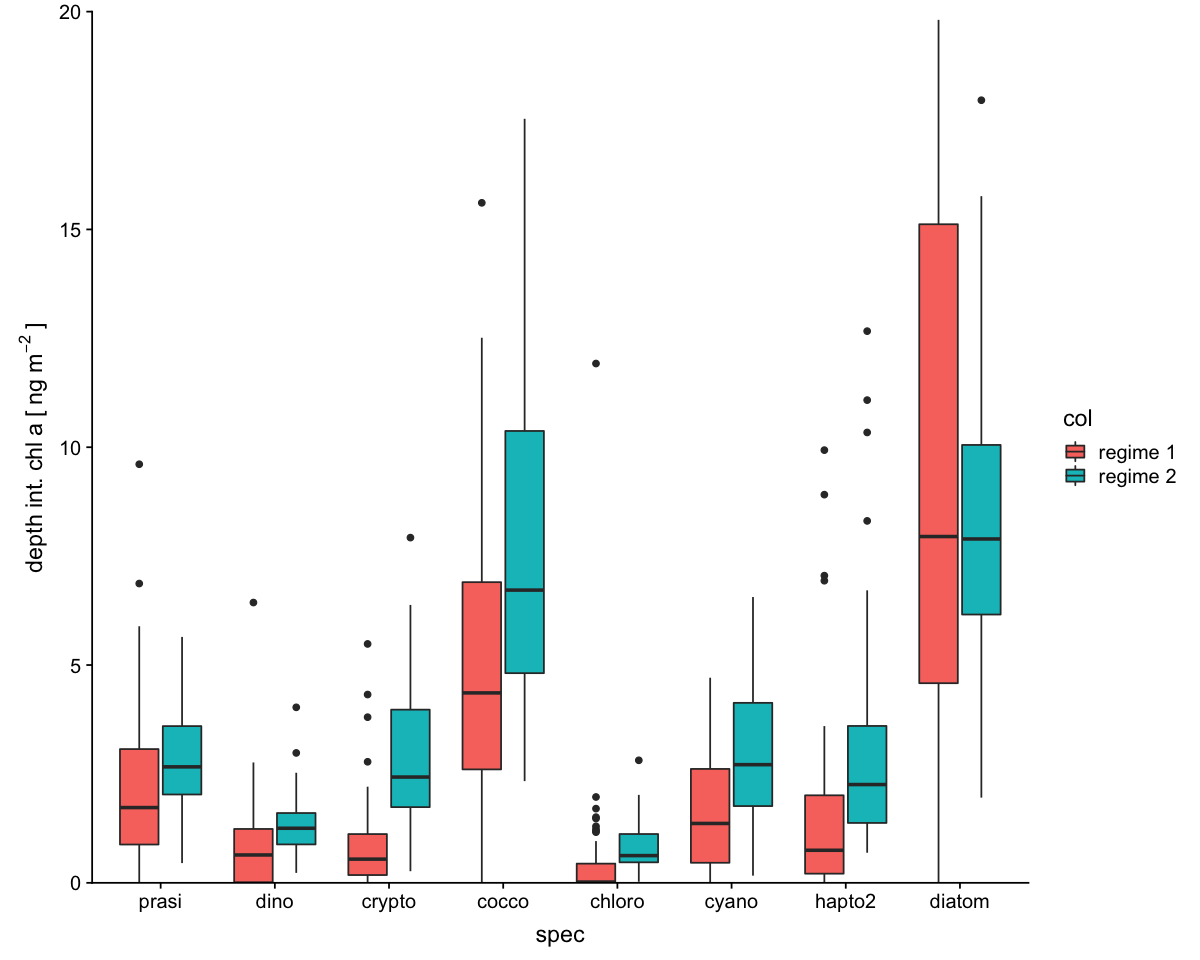

In [417]:
ggplot(data = FT_DataFrame, aes(y = depint_mean/1000, x = spec, fill = col)) + 
geom_boxplot() + ylab(expression(depth~int.~chl~a~'['~ng~m^{-2}~']')) + scale_y_continuous(limits=c(0,20), expand=c(0,0))


## 

In [438]:
Diatom1 <- data.frame('date'=FuncTypeChlA$Date, 'depth'=FuncTypeChlA$depth, 'chla'=FuncTypeChlA$Diatoms_Hapto1)
Diatom2 <- data.frame('date'=FuncTypeChlA$X2Date, 'depth'=FuncTypeChlA$X2depth, 'chla'=FuncTypeChlA$X2Diatoms_Hapto1)

In [440]:
str(Diatom1)

'data.frame':	449 obs. of  3 variables:
 $ date : POSIXct, format: "1995-12-14" "1995-12-14" ...
 $ depth: num  1 7 15 25 35 55 75 100 1 7 ...
 $ chla : num  68.6 79.1 87 162.4 98.6 ...


In [441]:
Diatom1_df <- Diatom1 %>%
  select(date, chla, depth) %>%
  gather(key='key',value = "value", -date, -depth)
head(Diatom1_df)

date,depth,key,value
1995-12-14,1,chla,68.62
1995-12-14,7,chla,79.13
1995-12-14,15,chla,86.97
1995-12-14,25,chla,162.44
1995-12-14,35,chla,98.61
1995-12-14,55,chla,45.06


In [448]:
zz <- seq(0, 100, 1)

Diatom1_int <- Diatom1_df %>%
    group_by(date) %>%
    filter(sum(!is.na(value))>2) %>%
    do(data.frame(value_int = with(.,approx(depth, value, zz, "linear")), depth = zz)) 


names(Diatom1_int)[names(Diatom1_int) == 'value_int.y'] <- 'value_int'
head(Diatom1_int)

date,value_int.x,value_int,depth
1995-12-14,0,NA,0
1995-12-14,1,68.62000,1
1995-12-14,2,70.37167,2
1995-12-14,3,72.12333,3
1995-12-14,4,73.87500,4
1995-12-14,5,75.62667,5


In [ ]:
require('zoo')

In [ ]:
data.frame(date = seq(MLD$date[1], MLD$date[nrow(MLD)], by = 1)) %>%
full_join(MLD, by = "date") %>%
mutate(approx = na.approx(value))


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

